Which features best predict 7-day retention?

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report
)


In [6]:
df = pd.read_csv("../data/raw/events_raw.csv")
df.head()


,user_id,event_time,event_type,used_choptrack,used_chopguide,first_event_time,days_since_first,retained_7d
0,1,2025-02-21 11:00:00,view_recipe,False,False,2025-02-21 11:00:00,0,False
1,1,2025-02-22 10:00:00,use_choptrack,True,False,2025-02-21 11:00:00,0,False
2,1,2025-02-24 17:00:00,view_recipe,False,False,2025-02-21 11:00:00,3,False
3,1,2025-02-25 18:00:00,save_recipe,False,False,2025-02-21 11:00:00,4,False
4,1,2025-03-03 12:00:00,login,False,False,2025-02-21 11:00:00,10,True


In [7]:
user_df = (
    df.groupby("user_id")
    .agg(
        total_events=("event_type", "count"),
        used_choptrack=("used_choptrack", "max"),
        used_chopguide=("used_chopguide", "max"),
        retained_7d=("retained_7d", "max")
    )
    .reset_index()
)

user_df.head()


,user_id,total_events,used_choptrack,used_chopguide,retained_7d
0,1,17,True,True,True
1,2,16,True,True,True
2,3,46,True,True,True
3,4,32,True,True,True
4,5,25,True,False,True


In [8]:
X = user_df[["total_events", "used_choptrack", "used_chopguide"]]
y = user_df["retained_7d"]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [11]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [12]:
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.9
ROC AUC: 0.4698765432098766

Classification Report

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        15
        True       0.90      1.00      0.95       135

    accuracy                           0.90       150
   macro avg       0.45      0.50      0.47       150
weighted avg       0.81      0.90      0.85       150



/Users/baeyoonseo/opt/anaconda3/envs/mcmc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/baeyoonseo/opt/anaconda3/envs/mcmc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/baeyoonseo/opt/anaconda3/envs/mcmc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [13]:
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)

feature_importance


,feature,coefficient
0,total_events,0.081883
1,used_choptrack,0.012645
2,used_chopguide,-0.169528


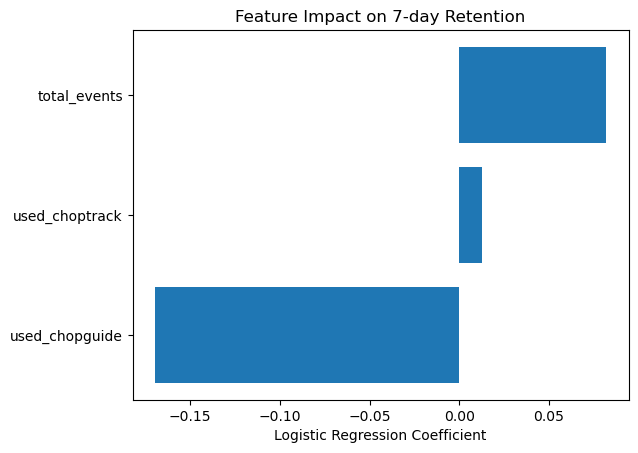

In [14]:
import matplotlib.pyplot as plt

plt.barh(
    feature_importance["feature"],
    feature_importance["coefficient"]
)
plt.xlabel("Logistic Regression Coefficient")
plt.title("Feature Impact on 7-day Retention")
plt.gca().invert_yaxis()
plt.show()


- (positive) : high retention posibility 
- (negative) : low retention posibility 

ChopGuide usage is negatively associated with retention, likely because it is used by users already at risk of churn
